# Object State Estimation with Kalman Filters

The following code snippets aim to tackle a basic object tracking / sensor fusion approach using a Kalman Filter.

Idea is simple: we will use the pre-processed CSV created from the "dataset_generation" notebook that represents a vehicle observed over a certain period of time using two radar sensors.

With these observations, we will implement object tracking followed by sensor fusion. The method of choice for the tasks is the (simple) Kalman Filter. Its theory and the required computations are briefly discussed in the `02_kalman_filter` notebook.

The notebook is structured as follows:
Our first goal is to use a Kalman Filter for object tracking in 1-dimensional (1D) space. Next is the extension to 2D; which is rather simple. The final task is to use the Kalman Filter to combine measurements from different sensors (aka. Sensor Fusion).


# Kalman Filter Implementation

Let's re-use the implementation provided in the `02_kalman_filter` notebook.

In [1]:
import numpy as np
from scipy.linalg import inv

class KalmanFilter(object):
    def __init__(self, P, F, R, Q, H, init_state = np.zeros((2)), num_states = 2):
        self.P = P
        self.F = F
        self.R = R
        self.Q = Q
        self.H = H
        self.num_states = num_states
        self.x = init_state

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        
    def update(self, z):
        # error
        y = z - self.H @ self.x
        # innovation
        S = self.H @ self.P @ self.H.T + self.R
        # Kalman gain
        K = self.P @ self.H.T @ inv(S)
        # update state and covariance
        self.x = self.x + (K @ y)
        self.P = (np.eye(self.num_states, self.num_states) - K @ self.H) @ self.P

## 1-Dimensional Tracking

The most simple way to see the Kalman Filter in action.

### Data

Since our goal is to use real data for the Kalman Filter, we will read in the pre-processed CSV created in the "dataset_generation" notebook.
The parts we are interested in are the global position of a vehicle: `x_seq` / `y_seq`.


In [2]:
import pandas as pd
radar_data = pd.read_csv("data/filtered_passenger_car_data.csv")

print(radar_data.head())

   Unnamed: 0     timestamp  sensor_id   range_sc  azimuth_sc        rcs  \
0          73  158195645746          2  18.291729    0.289267 -18.755455   
1          77  158195645746          2  20.424572    0.345797  14.521302   
2          78  158195645746          2  21.867811    0.382247  -5.828090   
3         419  158195668862          3  20.447489   -0.596640  18.738924   
4         420  158195668862          3  21.839920   -0.594027  -2.563722   

         vr  vr_compensated       x_cc      y_cc      x_seq      y_seq  \
0 -4.182464        0.077225  21.954672 -3.377731  3767.6875 -2645.4397   
1 -3.098473        1.191874  24.201195 -2.543640  3765.6868 -2646.7588   
2 -3.001787        1.301065  25.696009 -1.878942  3764.3804 -2647.7434   
3 -3.046643        1.186120  24.044230 -2.570582  3765.7312 -2646.7250   
4 -3.046207        1.188427  25.427788 -2.736952  3764.3457 -2646.8752   

                                  uuid                             track_id  \
0  b'bf76f24872ff61

Inspecting the data above closer, we can see that we seem to have almost too many data points.
First, the measurements result from different sensors. In order to keep things simple for now, we will use ony one sensor.

In [3]:
radar_data = radar_data[radar_data.sensor_id == 3]

We also seem to have a very high resolution on the timeseries as the timestamp is in microseconds. Hence, we will do some downsampling by selecting only every 50th item.

In [4]:
radar_data = radar_data.iloc[::50]
radar_data = radar_data.reset_index(drop=True)

With the reduced dataset, we can plot a path of the vehicle

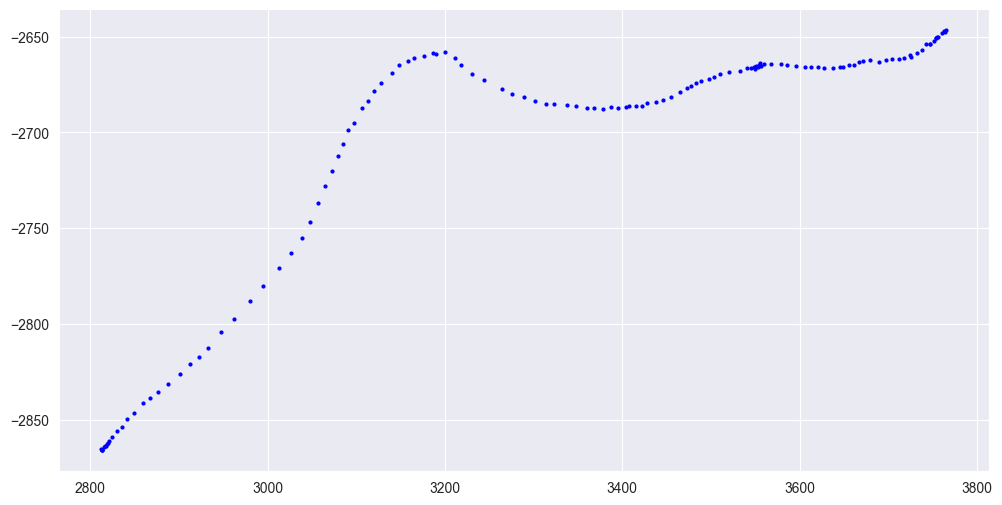

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize=(12,6))
plt.plot(radar_data.x_seq, radar_data.y_seq, "bo", markersize=2.0)

### Filtering

Initializing and running the Kalman Filter.

We will use the values defined above for the initialisation and run the `predict` and `update` steps iteratively for each data sample.

In [6]:
P = np.array([[10,0] , [0,5]])
F = np.array([[1, 1] , [0, 1]])
R = np.array([0.05])
Q = np.array([0.05, 0.05])
H = np.array([[1, 0]])

kf = KalmanFilter(P, F, R, Q, H)

In [7]:
filtered_x_values = []
for item in radar_data.x_seq:
    kf.predict()
    kf.update(item)
    filtered_x_values.append(kf.x[0])

### Visualize the results

Plotting the observed points along with the Kalman Filter values shows that the Kalman Filter results show a smoother path compared to the original observations. This effect will be more visible with the introduction of another dimension for the tracking (refer below).

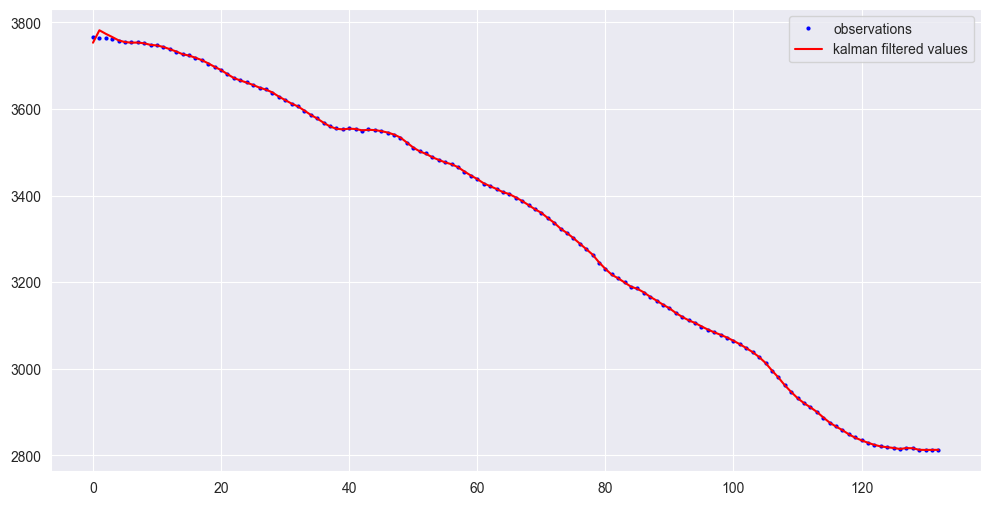

In [8]:
plt.figure(figsize=(12,6))
plt.plot(radar_data.x_seq, "bo", markersize=2.0)
plt.plot(filtered_x_values, "r")
plt.legend(['observations', 'kalman filtered values']) 

## 2-Dimensional Tracking

We have seen the one dimensional case where we are interested smoothing in one dimension but since we have access to a 2 dimensional position in our dataset, lets try to track in $x$ and $y$ direction.


We first need to define our `state vector`. We will use $x$ and $y$ along with their corresponding velocities (the hidden states).

$$
\bf{x} = \begin{bmatrix} x \\ \dot x \\ y \\ \dot y \end{bmatrix}
$$


where $\dot x$ and $\dot y$ represents the velocity in $x$ and $y$ direction.

Next is to design our `transition matrix`. Since we now have 2 measurements, we "stack" the 1 dimensional transition matrix along the diagonal and receive:

$$
\bf{F} = \begin{bmatrix} 
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}
$$


Same applies to the initial `covariance` 

$$
\bf{P} = \begin{bmatrix}
10 & 0 & 0 & 0 \\
0 & 5 & 0 & 0 \\
0 & 0 & 10 & 0 \\
0 & 0 & 0 & 5
\end{bmatrix}
$$
where we set the same covariances for the positions and velocities of $x$, $y$.


We would also need to adapt the `process noise` matrix

$$
\bf{Q} = \begin{bmatrix}
0 & .1 & 0 & 0 \\
.1 & .1 & 0 & 0 \\
0 & 0 & 0 & .1 \\
0 & 0 & .1 & .1
\end{bmatrix}
$$


For the `measurement function`, we indicate that the $x$ and $y$ values are the observable elements using


$$
H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$



Since our Kalman Filter implementation above is generic, all we need to do is define the matrices and update the inputs.

In [9]:
P = np.array([[5, 0, 0, 0],\
              [0, 5, 0, 0],\
              [0, 0, 5, 0],\
              [0, 0, 0, 5]])

F = np.array([[1, .1, 0, 0],\
              [0, 1, 0, 0],\
              [0, 0, 1, .1],\
              [0, 0, 0, 1]])

Q = np.array([[0, .1, 0, 0],\
              [.1, .1, 0, 0],\
              [0, 0, 0, .1],\
              [0, 0, .1, .1]])

R = np.array([[0.5, 0],
              [0, 0.5]])

H = np.array([[1, 0, 0, 0],\
              [0, 0, 1, 0]])

x_0 = np.array([radar_data.x_seq[0],0,radar_data.y_seq[0],0]) # initialze first state with actual measurement
kf = KalmanFilter(P, F, R, Q, H, x_0, num_states = 4)

In [10]:
filtered_x_values = []
filtered_y_values = []
#radar_data = radar_data[0:50]
for item in radar_data.itertuples():
    kf.predict()
    kf.update([item.x_seq, item.y_seq])
    filtered_x_values.append(kf.x[0])
    filtered_y_values.append(kf.x[2])    

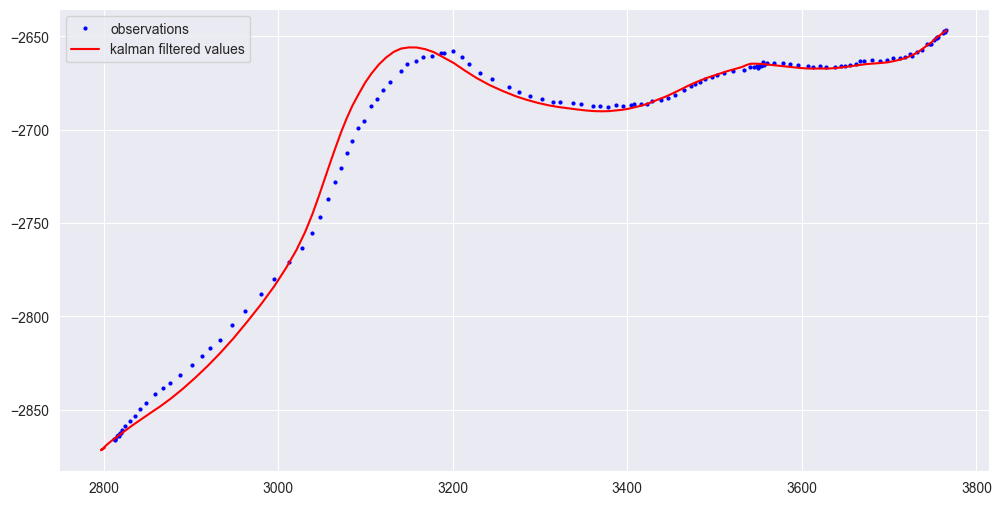

In [11]:
plt.figure(figsize=(12,6))
plt.plot(radar_data.x_seq, radar_data.y_seq, "bo", markersize=2.0)
plt.plot(filtered_x_values, filtered_y_values, "r")
plt.legend(['observations', 'kalman filtered values']) 

## Sensor Fusion

A very common application of Kalman Filters in probabilistic Robotics is Sensor Fusion that enables to use different sensors and hence improves tracking performance. It also allows to smoothen / filter values from potential contradicting measurements.

Since our dataset contains measurements from different sensors, we can utilize the benefits from Sensor Fusion.

In detail the dataset contains measurements from up to 4 sensors.


![vehicle.svg](img/vehicle.svg)

Source: https://radar-scenes.com/dataset/sensors/

Let us have quick look at the actual measurements from the sensors 2 and 3.

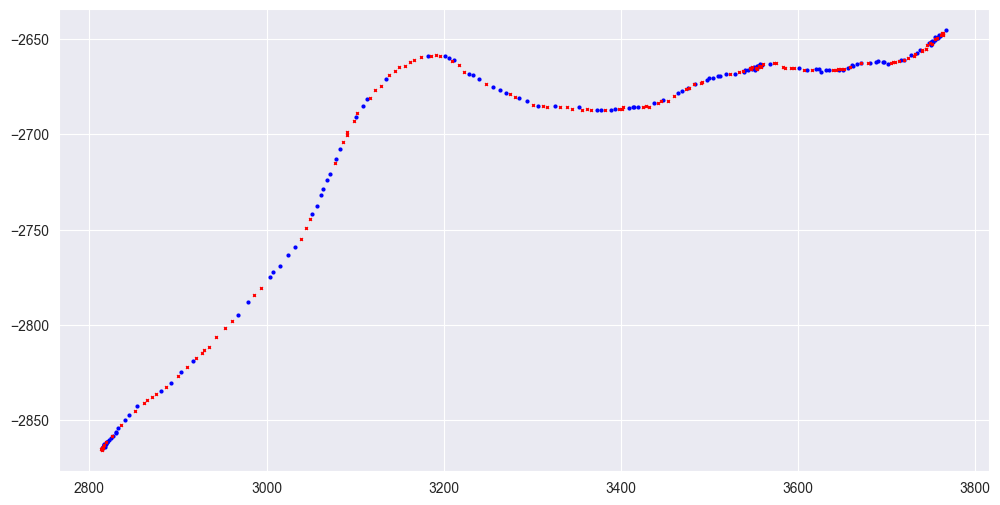

In [12]:
import pandas as pd
radar_data = pd.read_csv("data/filtered_passenger_car_data.csv")
radar_data = radar_data.iloc[::50] # do downsampling
radar_data = radar_data.reset_index(drop=True)
radar_data_sensor_2 = radar_data[radar_data.sensor_id == 2]
radar_data_sensor_3 = radar_data[radar_data.sensor_id == 3]
plt.figure(figsize=(12,6))

plt.plot(radar_data_sensor_2.x_seq, radar_data_sensor_2.y_seq, "bo", markersize=2.0)
plt.plot(radar_data_sensor_3.x_seq, radar_data_sensor_3.y_seq, "rx", markersize=2.0)


We can see that sensor 2 and 3 are complementing each other => let us use both for the tracking.

Since both sensors are identical, we do not need to initialize them separately within the Kalman Filter. Hence, we will take over the inital values used in 2-dimensional tracking.


In [13]:
P = np.array([[5, 0, 0, 0],\
              [0, 5, 0, 0],\
              [0, 0, 5, 0],\
              [0, 0, 0, 5]])

F = np.array([[1, .1, 0, 0],\
              [0, 1, 0, 0],\
              [0, 0, 1, .1],\
              [0, 0, 0, 1]])

Q = np.array([[0, .1, 0, 0],\
              [.1, .1, 0, 0],\
              [0, 0, 0, .1],\
              [0, 0, .1, .1]])

R = np.array([[0.5, 0],
              [0, 0.5]])

H = np.array([[1, 0, 0, 0],\
              [0, 0, 1, 0]])

x_0 = np.array([radar_data.x_seq[0],0,radar_data.y_seq[0],0]) # initialze first state with actual measurement
kf = KalmanFilter(P, F, R, Q, H, x_0, num_states = 4)


In order to iterate through the entire dataset and be able differ between the two sensors, we will combine them into a dataframe.

Since the Sensors are unfortunately not synchronized, implying that the observations are taken on different timestamps, we will merge them with an "outer join".

=> We will not change anything on the data, just change its representation.

,timestamp_sensor_2,x_seq_sensor_2,y_seq_sensor_2,timestamp_sensor_3,x_seq_sensor_3,y_seq_sensor_3
0,1.581956e+11,3767.6875,-2645.4397,NaN,NaN,NaN
1,NaN,NaN,NaN,1.581963e+11,3763.7168,-2647.1155
2,NaN,NaN,NaN,1.581966e+11,3763.3843,-2647.3928
3,NaN,NaN,NaN,1.581971e+11,3764.0625,-2647.7583
4,NaN,NaN,NaN,1.581974e+11,3762.7960,-2647.0234
...,...,...,...,...,...,...
263,1.583330e+11,2814.4030,-2864.6301,NaN,NaN,NaN
264,NaN,NaN,NaN,1.583332e+11,2813.8948,-2864.7600
265,1.583335e+11,2816.0264,-2863.1997,NaN,NaN,NaN
266,1.583338e+11,2814.4004,-2865.3103,NaN,NaN,NaN


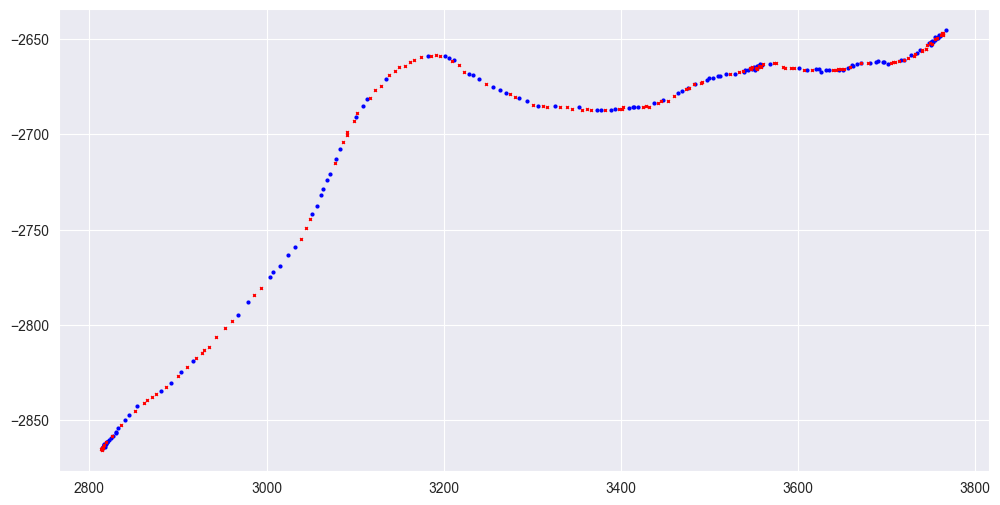

In [14]:
radar_data_sensor_2 = radar_data_sensor_2[["timestamp", "x_seq", "y_seq"]]
radar_data_sensor_3 = radar_data_sensor_3[["timestamp", "x_seq", "y_seq"]]
radar_data_sensor_combined = radar_data_sensor_2.join(radar_data_sensor_3,  how="outer", lsuffix='_sensor_2', rsuffix='_sensor_3')
plt.figure(figsize=(12,6))
plt.plot(radar_data_sensor_combined.x_seq_sensor_2, radar_data_sensor_combined.y_seq_sensor_2, "bo", markersize=2.0)
plt.plot(radar_data_sensor_combined.x_seq_sensor_3, radar_data_sensor_combined.y_seq_sensor_3, "rx", markersize=2.0)
radar_data_sensor_combined

Now, the fusion of two sensors is achieved by calling the `update` function once per sensor. We will do exactly that. Since we are not sure if we have two sensor inputs at any specific timestamp, we will check for NaNs prior to executing `update`.

In [15]:
import numpy as np
fused_x_values = []
fused_y_values = []
#radar_data = radar_data[0:50]
for item in radar_data_sensor_combined.itertuples():
    kf.predict()
    if not (np.isnan(item.x_seq_sensor_2) and np.isnan(item.y_seq_sensor_2)):
        kf.update([item.x_seq_sensor_2, item.y_seq_sensor_2])

    if not (np.isnan(item.x_seq_sensor_3) and np.isnan(item.y_seq_sensor_3)):
        kf.update([item.x_seq_sensor_3, item.y_seq_sensor_3])

    fused_x_values.append(kf.x[0])
    fused_y_values.append(kf.x[2])

<Figure size 1200x600 with 0 Axes>

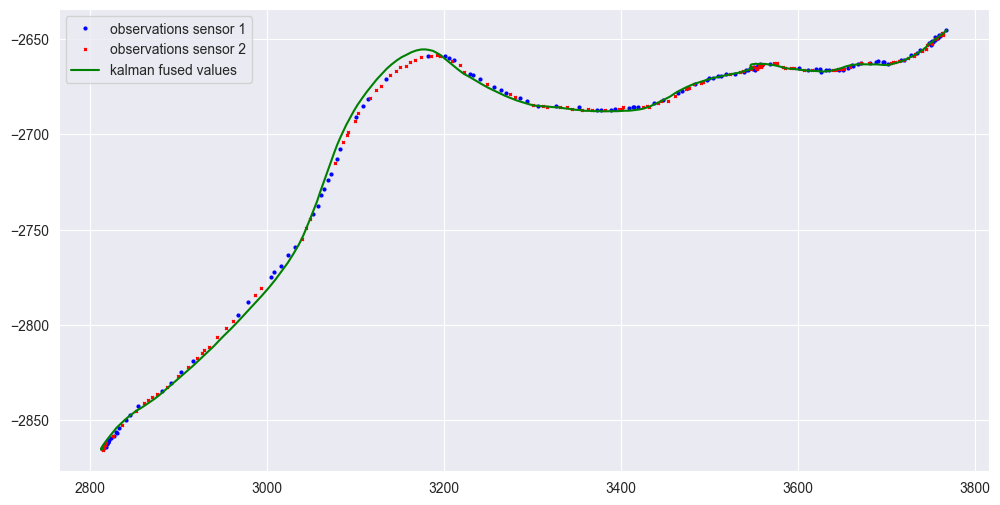

In [16]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
plt.plot(radar_data_sensor_combined.x_seq_sensor_2, radar_data_sensor_combined.y_seq_sensor_2, "bo", markersize=2.0)
plt.plot(radar_data_sensor_combined.x_seq_sensor_3, radar_data_sensor_combined.y_seq_sensor_3, "rx", markersize=2.0)
plt.plot(fused_x_values, fused_y_values, "g")

plt.legend(['observations sensor 1', 'observations sensor 2', 'kalman fused values']) 

We can now compare the Kalman filtered $x$ and $y$ values of one sensor created above and the Kalman fused values.

<Figure size 1200x600 with 0 Axes>

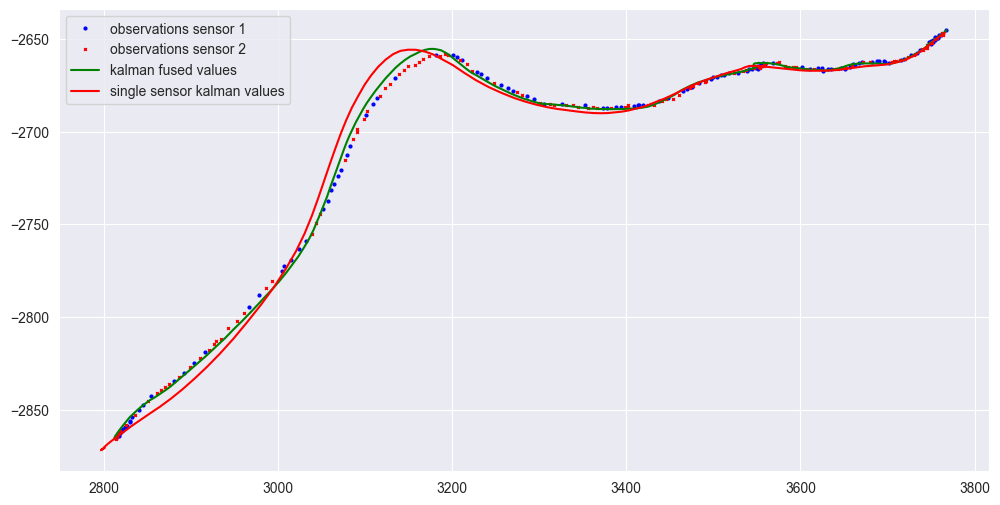

In [17]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
plt.plot(radar_data_sensor_combined.x_seq_sensor_2, radar_data_sensor_combined.y_seq_sensor_2, "bo", markersize=2.0)
plt.plot(radar_data_sensor_combined.x_seq_sensor_3, radar_data_sensor_combined.y_seq_sensor_3, "rx", markersize=2.0)
plt.plot(fused_x_values, fused_y_values, "g")
plt.plot(filtered_x_values, filtered_y_values, "r")

plt.legend(['observations sensor 1', 'observations sensor 2',  'kalman fused values' , 'single sensor kalman values']) 

=> the results indicate that our fused estimate is very close to the actual observations (but smoother).